## Table of Contents
<a id='contents'></a>

[Python working setup](#pySetup)

[Species accumulation curves](#SAC)

[Turnover diagrams by habitat](#Turnover)

[Ordination by habitat](#NMS)

[hierarchical clustering of sites](#hierarch)

<a id='pySetup'></a>
### Python working setup

In [2]:
import os
import openpyxl
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from sklearn.linear_model import LinearRegression
import scipy.spatial as sp

I did a bit of data cleaning of Ana's raw data, to create the following working dataframe. It has most of what I need up to this point:

In [5]:
specObs = pd.read_pickle('specObs.p')
specObs.head()

,site,parcela,subparcela,PsubP,familia,genero,especie,genusSpecies,habito,elevacion,habitat
1,1,1,1,1.1,Flacourtiaceae,Banara,regia,Flacourtiaceae Banara regia,Árbol,1425,RG
2,1,1,1,1.1,Melastomataceae,Leandra,subseriata,Melastomataceae Leandra subseriata,Arbolito,1413,RG
3,1,1,1,1.1,Melastomataceae,Ossaea,micrantha,Melastomataceae Ossaea micrantha,Arbolito,1413,RG
4,1,1,1,1.1,Melastomataceae,Ossaea,micrantha,Melastomataceae Ossaea micrantha,Arbolito,1413,RG
5,1,1,1,1.1,Cecropiaceae,Cecropia,reticulata,Cecropiaceae Cecropia reticulata,Árbol,1413,RG


For all of the analyses conducted so far, I have used the subplot as a basic sampling unit. These are denoted in the PsubP column, where the first number is the plot, and the number after the decimal is a subplot. Together they make a unique identifier. 

From this we can make a general site x species matrix:

In [15]:
smallSpecObs = specObs[['PsubP','genusSpecies']]
bdfDummy = pd.get_dummies(smallSpecObs['genusSpecies'])
bdfDummy.insert(0, 'PsubP', smallSpecObs.PsubP)
bdfDummyGroup = bdfDummy.groupby('PsubP')
subParcelComm = bdfDummyGroup.agg(np.sum)
subParcelComm.head()

,Actinidaceae Saurauia sp. 1,Anacardiaceae Mauria cf. heterophylla,Anacardiaceae Tapirira guianensis,Annonaceae Guatteria cf. megalophylla,Annonaceae Guatteria megalophylla,Annonaceae Guatteria sp.,Annonaceae Rollinia aff. dolichopetala,Annonaceae Rollinia edulis,Annonaceae sp.,Aquifoliaceae Ilex cf. yurumanguinis,...,Theophrastaceae Clavija eggersiana,Theophrastaceae Clavija membranacea,Thymelaeaceae Schoenobiblus daphnoides,Ulmaceae Trema micrantha,Urticaceae Boehmeria caudata,Urticaceae Urera aff. caracasana,Urticaceae Urera baccifera,Urticaceae Urera caracasana,Verbenaceae Aegiphila alba,Violaceae Gloeospermum longifolium
PsubP,,,,,,,,,,,,,,,,,,,,,
1.1,5,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1.4,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1.5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


Exploring our data a bit:

In [8]:
specObs.columns

Index(['site', 'parcela', 'subparcela', 'PsubP', 'familia', 'genero',
       'especie', 'genusSpecies', 'habito', 'elevacion', 'habitat'],
      dtype='object')

In [6]:
specObs.shape

(2737, 11)

2737 observations, each one representing a collection of a plant. Lots of plants. How many species observed?

In [10]:
len(specObs.genusSpecies.unique())

343

[back to top](#contents)

<a id="SAC"></a>
### Species accumulation curves

We can split up our site-by-species matrix by habitat, in python:

aa = specObs[['PsubP', 'habitat']].drop_duplicates()
aa.set_index('PsubP', inplace=True)
bb = pd.concat([aa, subParcelComm], axis=1)
bbGrouped = bb.groupby('habitat')
habs = list(bbGrouped.groups.keys())

for i in habs:
    cc = bbGrouped.get_group(i)
    observed = (cc != 0).any(axis=0).values
    dd = cc.iloc[:,observed]
    dd.drop('habitat', axis=1, inplace=True)
    dd.to_csv(f'{i}_comm.csv')

Now we can use these smaller dataframes to make turnover graphs and do chao estimates. Back to R:

In [4]:
library(vegan)
library(RColorBrewer)
library(repr)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



[1] "subParcelComm.csv"
[1] "BC_comm.csv"
[1] "BS_comm.csv"
[1] "CLB_comm.csv"
[1] "RCA_comm.csv"


Warning message in cor(x > 0):
“the standard deviation is zero”


[1] "RG_comm.csv"


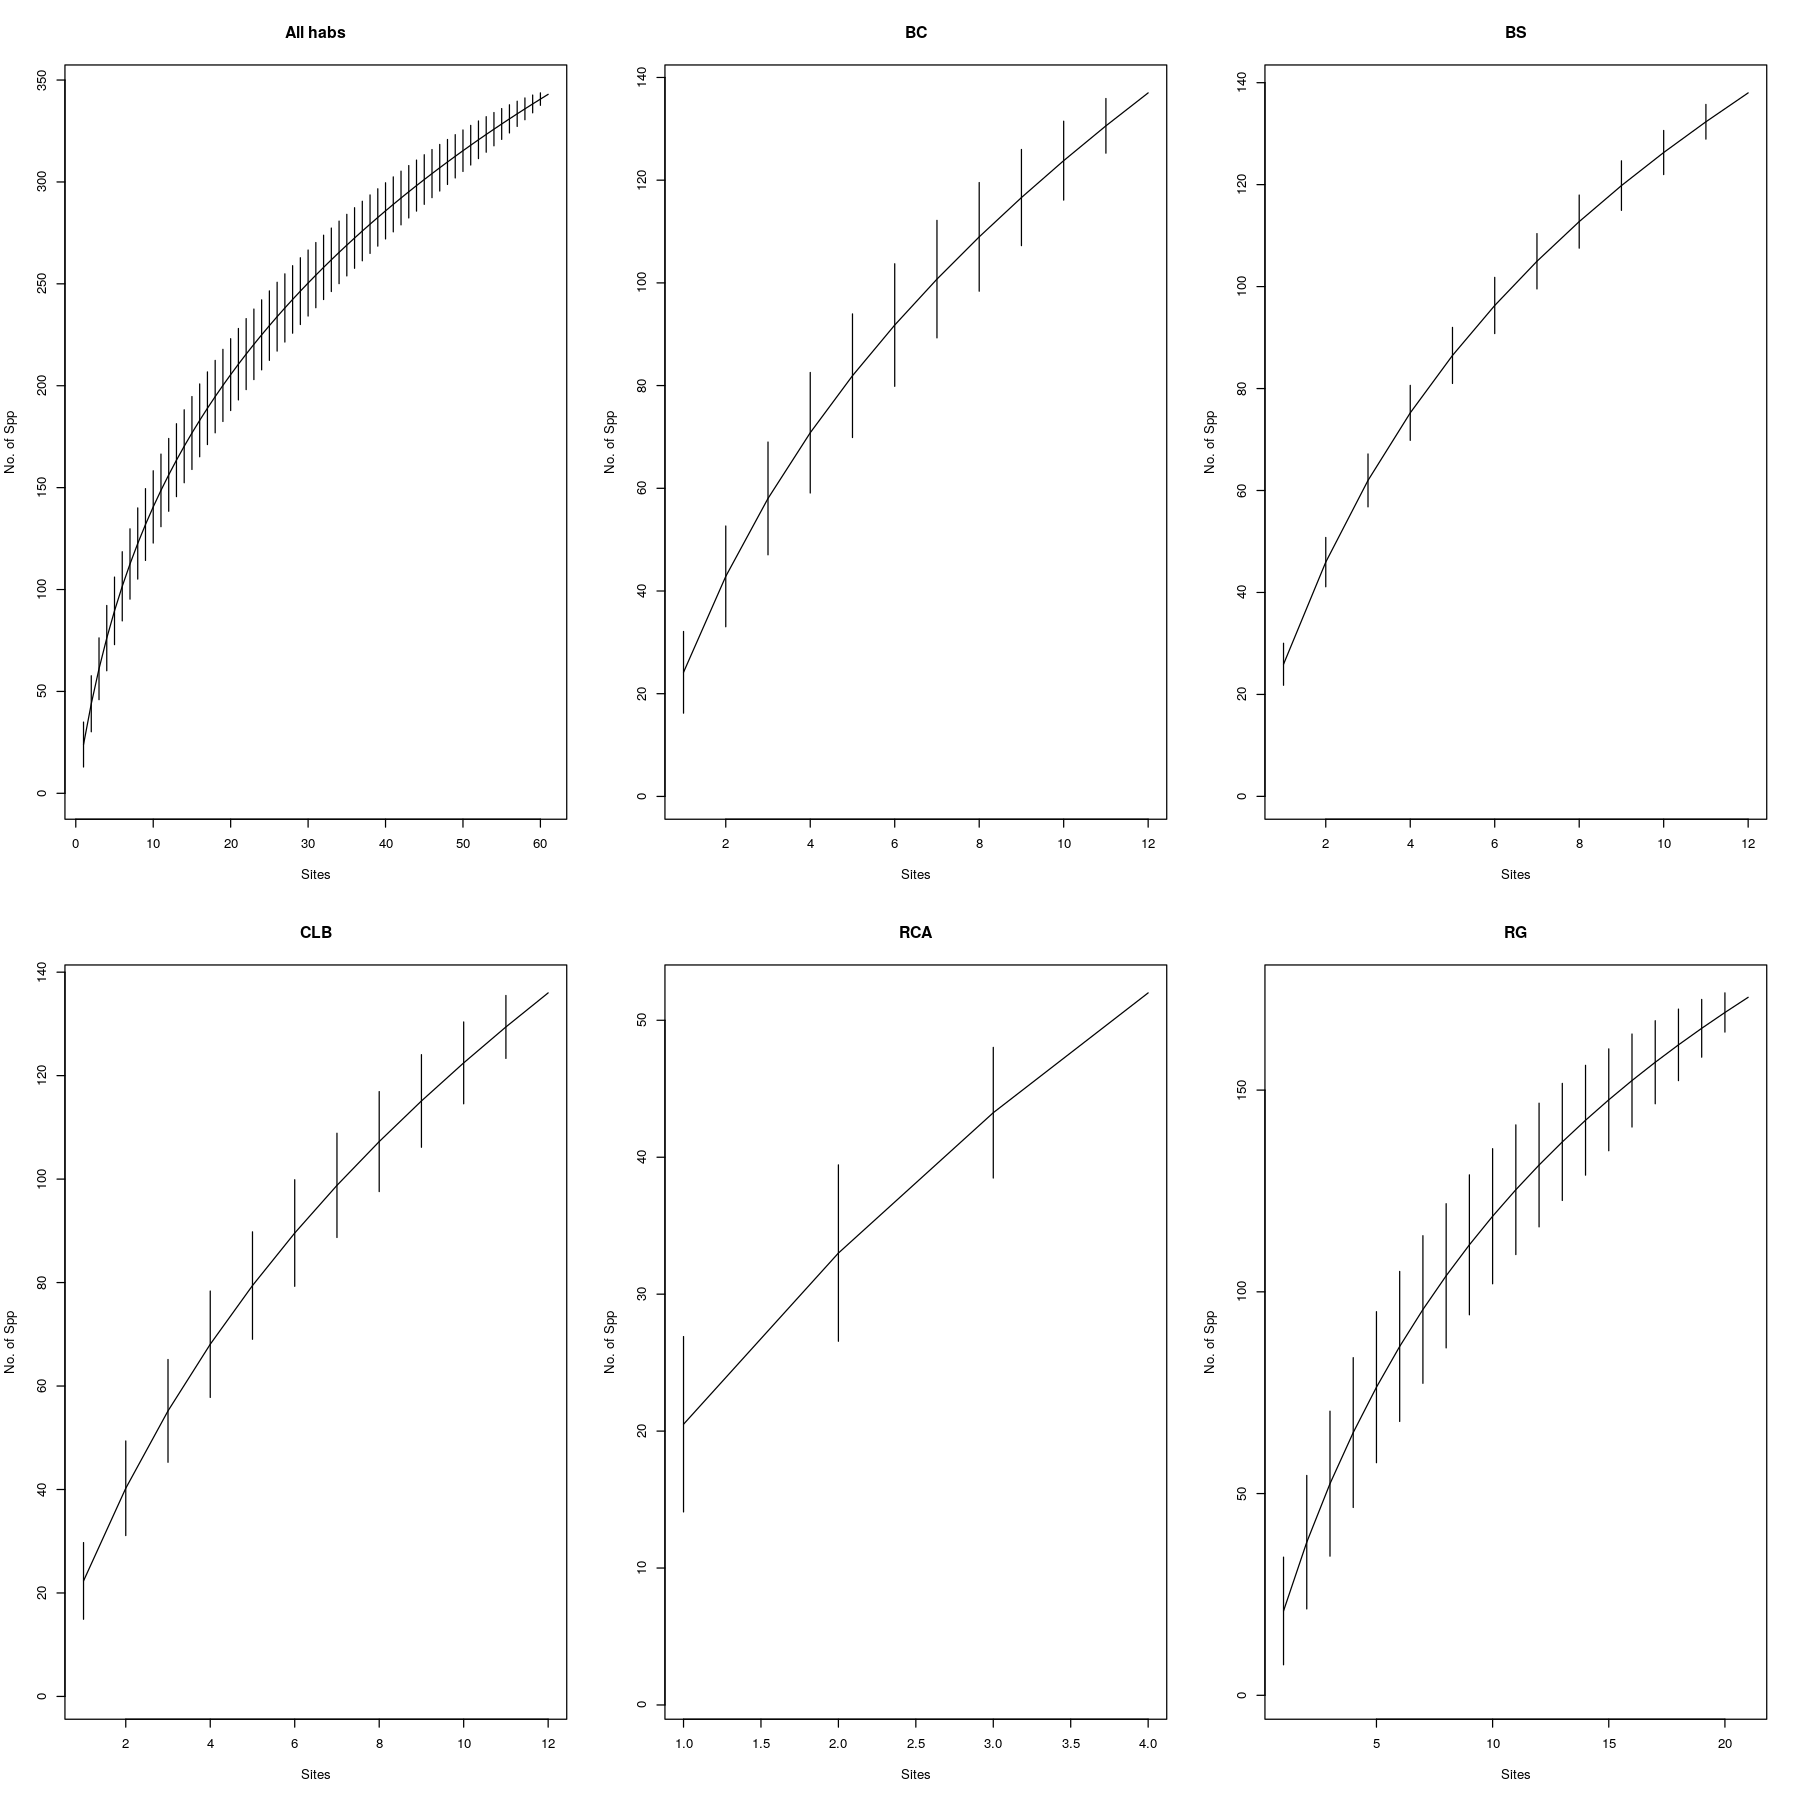

In [7]:
options(repr.plot.width=15, repr.plot.height=15)
par(mfrow = c(2,3))
files <- list.files()
comm <- grep('_comm.csv', list.files())
comms <- files[comm]
comms <- c("subParcelComm.csv", comms)
comtitles <- sub("_comm.csv", "", comms)
comtitles[1] <- "All habs"
j <- 0
for (i in comms){
    j <- j + 1
    comm.i <- read.csv(i, header=TRUE, row.names=1)
    print(i)
    SAC <- specaccum(comm.i, method = "exact")
    plot(SAC, main=comtitles[j], ylab='No. of Spp')
    capture.output(print(paste('Species estimates for', comtitles[j], sep=" ")),
                    file="habSRestimates.txt", append = TRUE)
    capture.output(specpool(comm.i),
                    file="habSRestimates.txt",
                    append = TRUE)
    sacDF <- data.frame(cbind(SAC$richness, SAC$sd), row.names=SAC$sites)
    colnames(sacDF) <- c('richness', 'sd')
    write.csv(sacDF, file=paste(comtitles[j], "SAC.csv", sep="_"))
}

Chao estimators for these:

[back to top](#contents)

<a id='Turnover'></a>
### Turnover diagrams by habitat

Let's check turnover rates in these various habitat types:

BC


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


BS


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


CLB


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RCA


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


RG


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


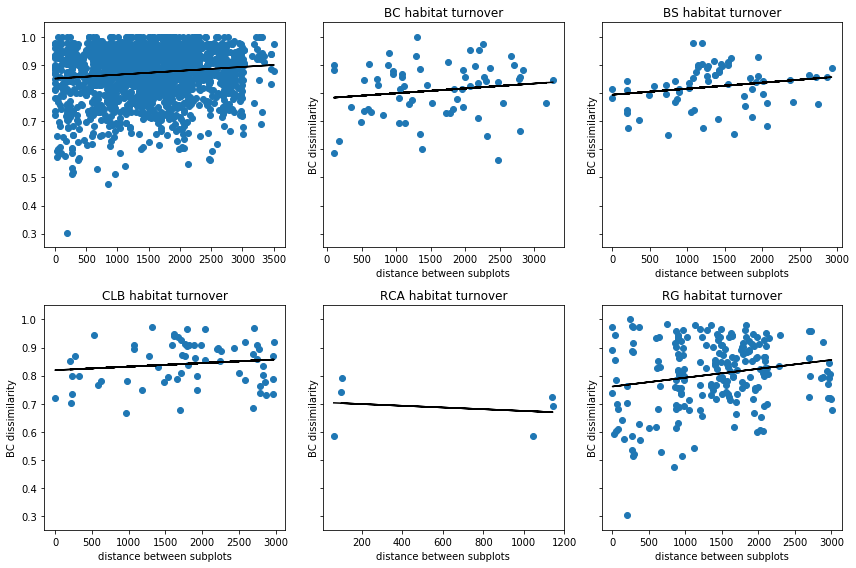

In [10]:
specObs = pd.read_pickle('specObs.p')
spDF = pd.read_pickle('subParcelSpatial.p')
subParcelComm = pd.read_pickle("subParcelComm.p")

## get our original in there first:
fig, axes = plt.subplots(nrows=2, ncols=3, sharey=True, figsize=(12,8))
axes = axes.flatten()

physDist = sp.distance.pdist(spDF, metric='euclidean')
bcDist = sp.distance.pdist(subParcelComm, metric='brayCurtis')
X, Y = physDist.reshape(-1,1), bcDist.reshape(-1,1)
axes[0].scatter(physDist, bcDist)
axes[0].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')

soGrouped = specObs.groupby('habitat')
habs = list(soGrouped.groups.keys())

for h,i in enumerate(habs):
    print(i)
    obs_i = soGrouped.get_group(i)
    obs_iN = [ spDF.loc[a].N for a in obs_i.PsubP ]
    obs_iE = [ spDF.loc[a].E for a in obs_i.PsubP ]
    obs_i['N'] = obs_iN
    obs_i['E'] = obs_iE
    subParcelInObs_i = subParcelComm.index.isin(obs_i.PsubP)
    comm_i = subParcelComm[subParcelInObs_i]
    notObserved=~((comm_i == 0).all(axis=0).values)
    comm_i = comm_i.iloc[:,notObserved]
    spDF_i = spDF.loc[comm_i.index.values]
    physDist_i = sp.distance.pdist(spDF_i, metric='euclidean')
    bcDist_i = sp.distance.pdist(comm_i, metric='brayCurtis')
    axes[h+1].scatter(physDist_i, bcDist_i)
    X, Y = physDist_i.reshape(-1,1), bcDist_i.reshape(-1,1)
    axes[h+1].plot( X, LinearRegression().fit(X, Y).predict(X), c='k')
    axes[h+1].set_xlabel('distance between subplots')
    axes[h+1].set_ylabel('BC dissimilarity')
    axes[h+1].set_title(f'{i} habitat turnover')
    
    plt.tight_layout()

[back to top](#contents)

<a id='NMS'></a>
### Ordination by habitat

Let's see how these habitats separate out, if at all. We'll need to do this in R.

In [2]:
library(vegan)
library(RColorBrewer)

Loading required package: permute

Loading required package: lattice

This is vegan 2.5-6



In [3]:
subParcelComm <- read.csv('subParcelComm.csv', header=TRUE)
sPC <- subParcelComm[,-1]
rownames(sPC) <- subParcelComm[,1]

In [4]:
nms <- metaMDS(sPC, try=40)

Wisconsin double standardization
Run 0 stress 0.2882666 
Run 1 stress 0.2882529 
... New best solution
... Procrustes: rmse 0.01348806  max resid 0.04924752 
Run 2 stress 0.2909521 
Run 3 stress 0.2897332 
Run 4 stress 0.288267 
... Procrustes: rmse 0.01365625  max resid 0.04984544 
Run 5 stress 0.3181376 
Run 6 stress 0.2896983 
Run 7 stress 0.2935064 
Run 8 stress 0.3198944 
Run 9 stress 0.2898472 
Run 10 stress 0.2882125 
... New best solution
... Procrustes: rmse 0.0101975  max resid 0.04870113 
Run 11 stress 0.2882662 
... Procrustes: rmse 0.008665411  max resid 0.04862825 
Run 12 stress 0.297176 
Run 13 stress 0.2907497 
Run 14 stress 0.2909597 
Run 15 stress 0.2892083 
Run 16 stress 0.2914792 
Run 17 stress 0.2910264 
Run 18 stress 0.2909273 
Run 19 stress 0.2882346 
... Procrustes: rmse 0.007382106  max resid 0.04682058 
Run 20 stress 0.2882529 
... Procrustes: rmse 0.01010734  max resid 0.0476653 
Run 21 stress 0.2897464 
Run 22 stress 0.320755 
Run 23 stress 0.2909605 
Run 24

Stresses look high...check them out a little more closely:

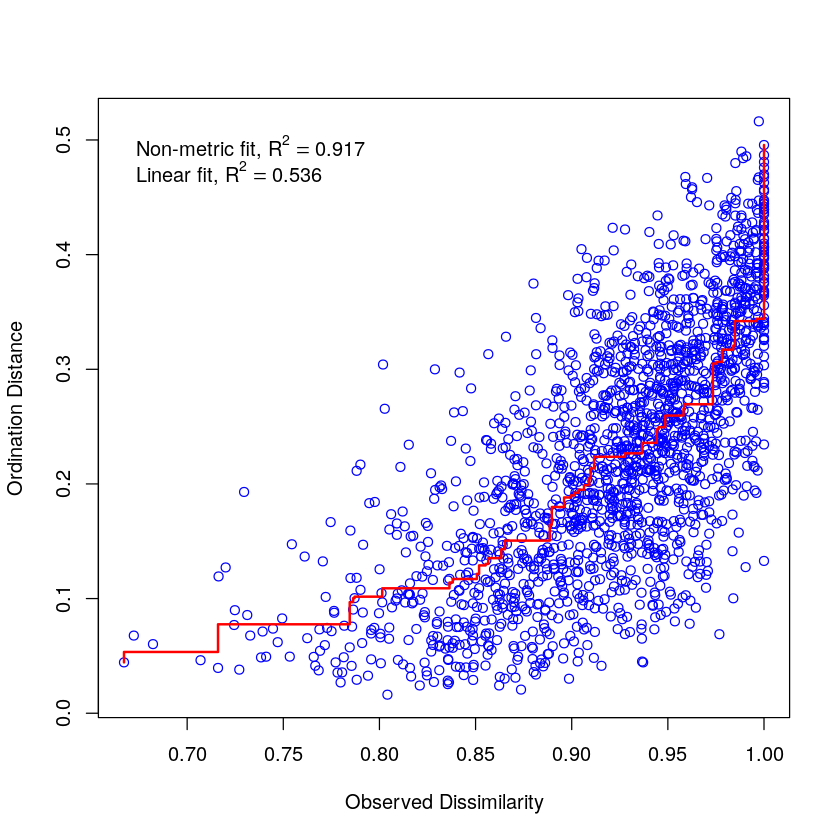

In [5]:
stressplot(nms)

Not great, but might be useful. Most of the solutions are under 0.3...let's look at the one that was saved:

In [7]:
specObs <- read.csv('specObs.csv')
aa = specObs[c("PsubP","habitat")]
colrs <- brewer.pal(5, "Set1")
nondups <- aa[!duplicated(aa),]
nondups <- nondups[order(nondups$PsubP),]
rownames(nondups) <- NULL
nondups$colorNu <- as.numeric(nondups$habitat)
nondups$colrs <- colrs[nondups$colorNu]
nondups$MDS1 <- nms$points[,'MDS1']
nondups$MDS2 <- nms$points[,'MDS2']
nmsInfo <- nondups

null device 
          1

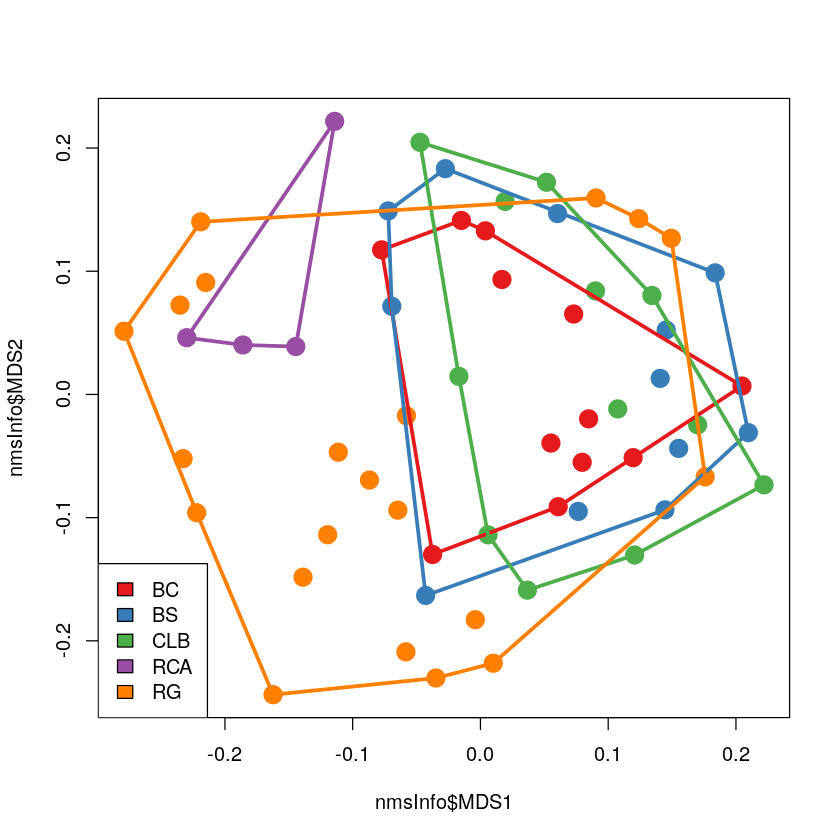

In [10]:
plot(nmsInfo$MDS1, nmsInfo$MDS2,
    col=nmsInfo$colrs,
    pch=19,
    cex=2.0,
)
## add a legend
legend( x='bottomleft',
        legend = c('BC', 'BS', 'CLB', 'RCA', 'RG'),
        fill = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        col = c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'),
        cex = 1.0,
        )
ordihull(nms, nmsInfo$habitat, col=c('#E41A1C', '#377EB8', '#4DAF4A', '#984EA3', '#FF7F00'), lwd=3)


BC - Bosque cerrado  
BS - Bosque secundario  
CLB - Claro de bosque  
RG - regeneración fincas agricultura ganadería  
RCA - Regeneración cañaveral  

<a id="hierarch"></a>
### Hierarchical clustering of sites
    
Let's see if this clustering we see in the NMS is noticeable with a hierarchical clustering method, as another way of tracking similarities among sites in species composition.

In [14]:
makeClustMap <- function(tree, k, labels=NULL, jit=50){
    envOnly <- read.csv('envOnly.csv')
    pts <- read.csv('subParcelSpatial.csv')
    require(stats)
    ## get habitat type labels for tree
    if (is.null(labels)){lab <- NULL}
    else { 
        if (labels=='hab'){
        lab <- vector(length = length(tree$labels))
        for (i in 1:length(tree$labels)){
            ind <- which(envOnly$PsubP==tree$labels[i])
            lab[i] <- as.character(envOnly$habitat[ind])
    }}}
    par(mfrow=c(2,1))
    plot(tree, labels=lab)
    clustGroups <- rect.hclust(tree, k=k, border=1:k)
    cmem <- vector(length=k)
    PsubP <- vector()
    gr <- vector()
    for (i in 1:k){
        cmem.i <- as.numeric(attr(clustGroups[[i]], "names"))
        PsubP <- c(PsubP, cmem.i)
        gr <- c(gr, rep(i, length(cmem.i)))
        }
    cGroup <- data.frame(cbind(PsubP, gr))
    cGroup <- cGroup[order(cGroup$PsubP),]
    pts <- pts[order(pts$PsubP),]
    clsp <- base::merge(pts, cGroup)
    clsp <- base::merge(clsp, envOnly)
    shapes <- vector(length=nrow(clsp))
    shapes[clsp$habitat == 'BC'] <- 19
    shapes[clsp$habitat == 'BS'] <- 21
    shapes[clsp$habitat == 'CLB'] <- 22
    shapes[clsp$habitat == 'RCA'] <- 17
    shapes[clsp$habitat == 'RG'] <- 23
    eJit=jitter(clsp$E, jit)
    nJit=jitter(clsp$N, jit)
    plot(x=eJit,
        y=nJit,
        col=clsp$gr,
        xlab='',
        ylab='',
        xlim=c(745000,749000),
        asp=1,
        cex=2,
        lwd=2,
        pch=shapes,
    )
    #legend('bottomright',
    #    legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
    #    pch=c(19, 21, 22, 17, 23)
    #)
    #legend('bottomleft',
    #    legend=1:k,
    #    pch=c(15),
    #    col=1:k,
    #    title='ClusterGroup')
    #return(clsp)
    }


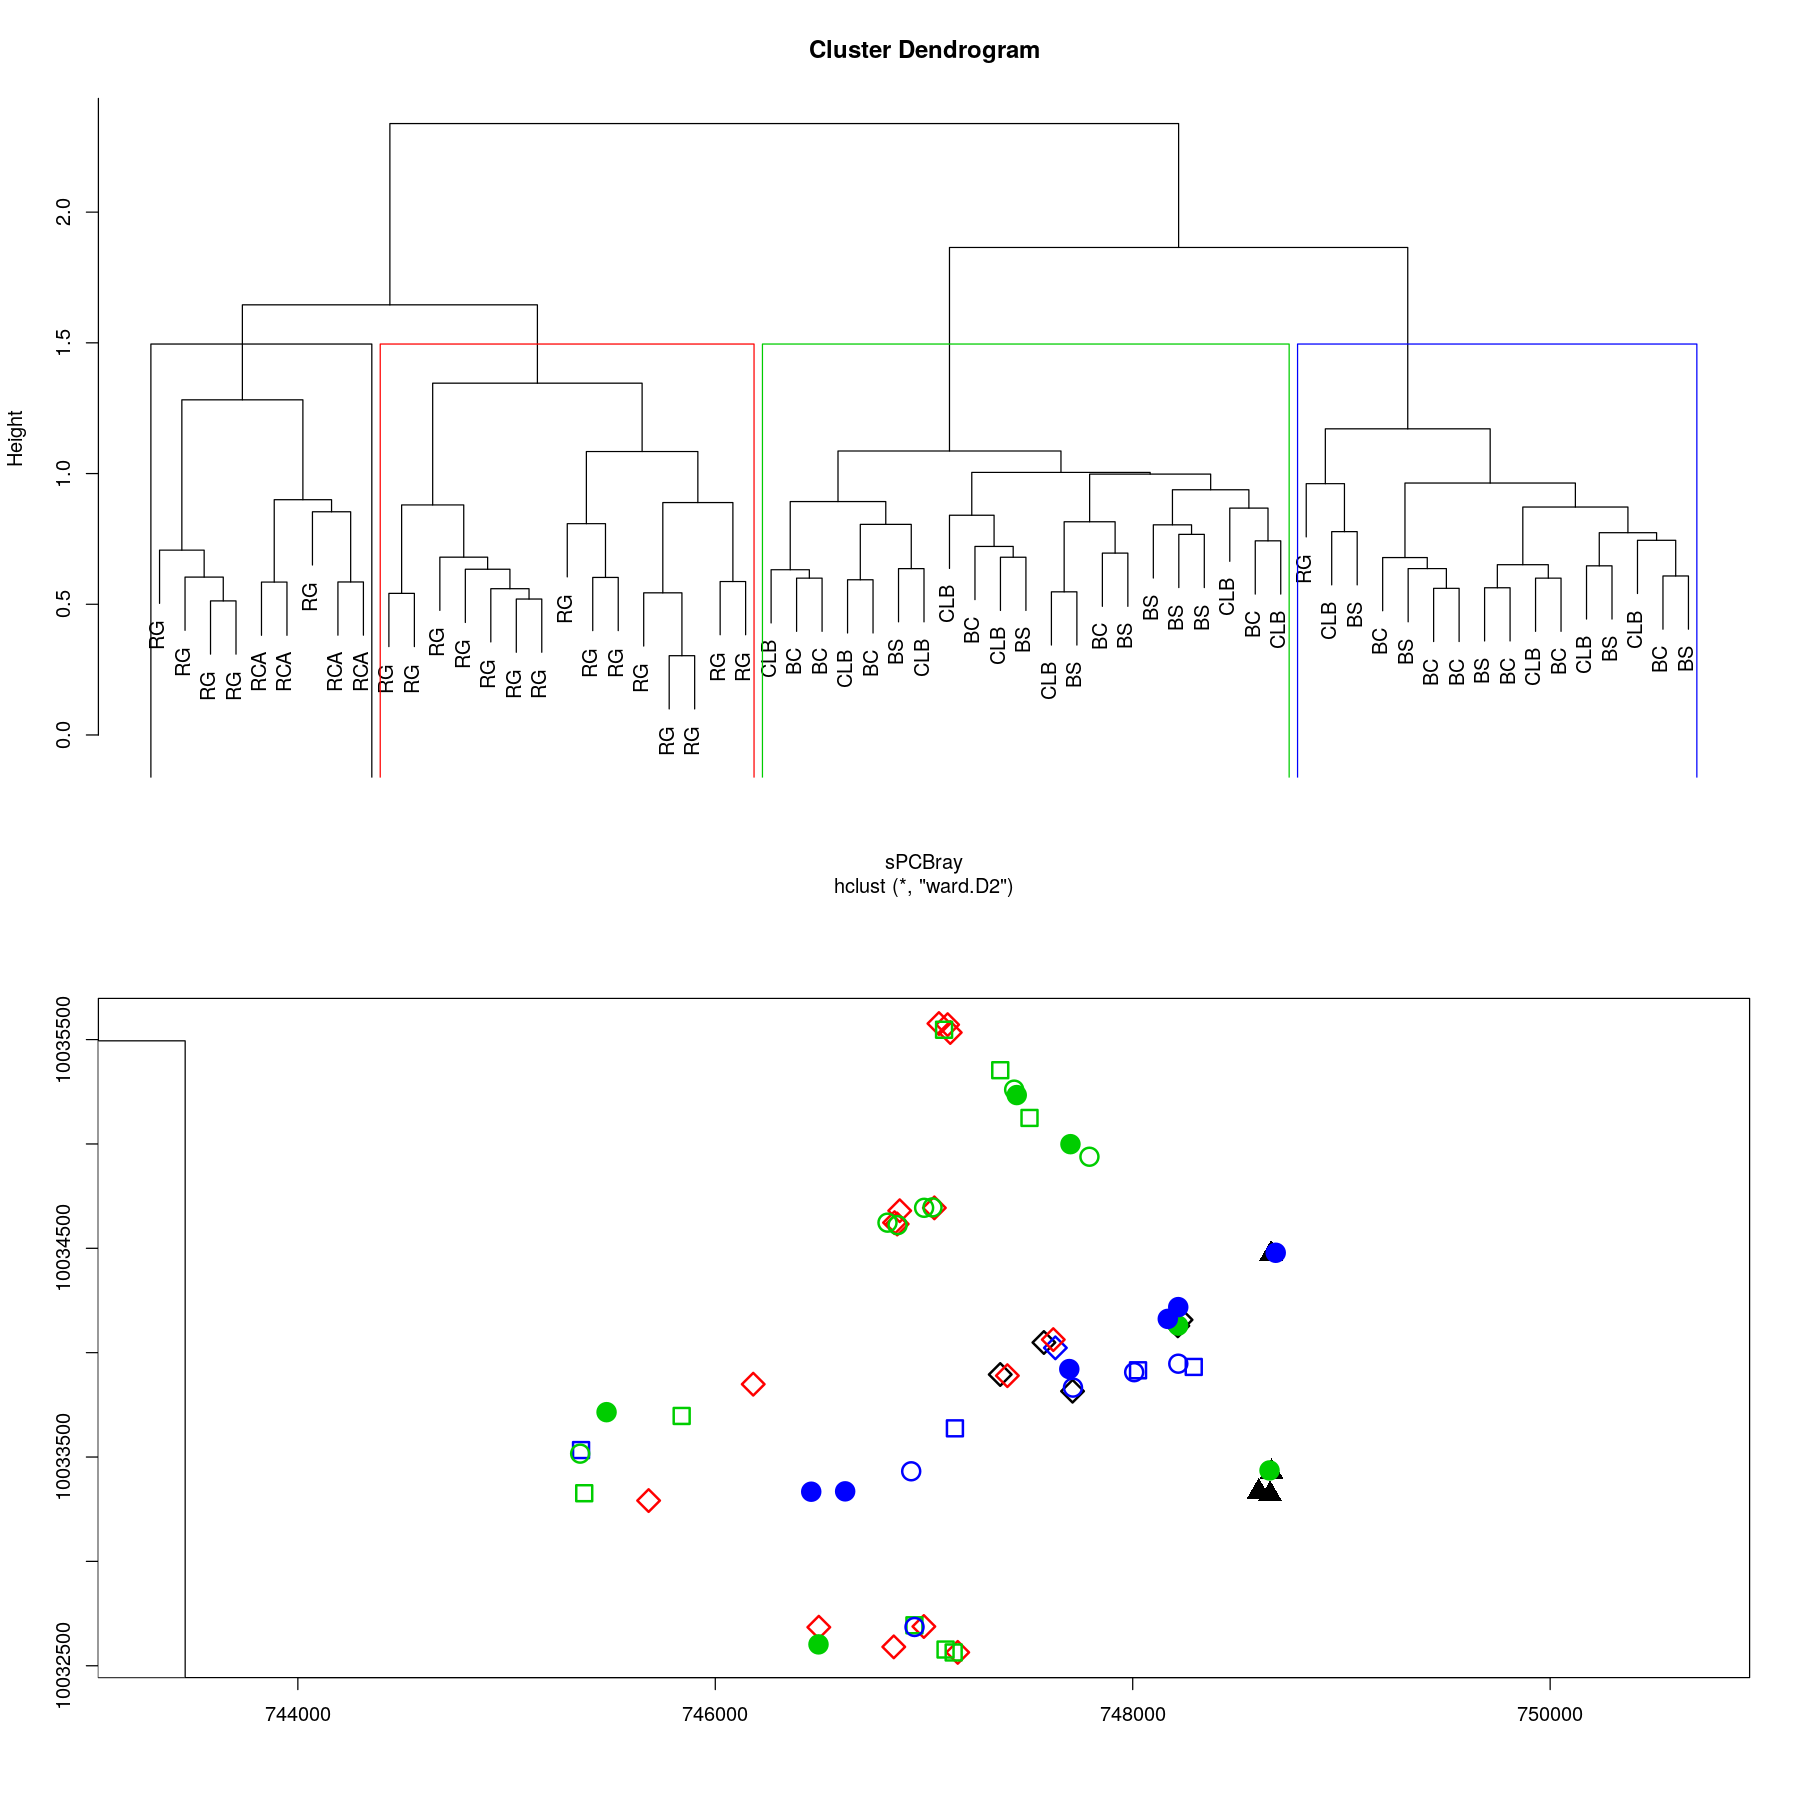

In [15]:
options(repr.plot.width=15, repr.plot.height=15)
bb <- makeClustMap(sPC.ward, k=4, labels='hab')
legend('bottomright',
    legend=c('BC', 'BS', 'CLB', 'RCA', 'RG'),
    pch=c(19, 21, 22, 17, 23)
)

legend('bottomleft',
    legend=1:k,
    pch=c(15),
    col=1:k,
    title='ClusterGroup')


In the tree above, the RCA plots are again by themselves in a group, with a few RG plots. The closest "relative" of these RCA plots is a section that contains the majority of the RG plots, group 2, in red. The other two groups (groups 3/green and 4/blue) form a section major branch, and contain most of the secondary and closed forest, and the natural gaps. Interesting that the gaps cluster in with the forest so distinctly from the regen sites. The split in the forest groups, 3 & 4, may be showing the difference between riparian and upland sites, but needs a closer look. 

The second graph is a physical map, reflecting the distances among the points. Legend was lost here...to be corrected.  

[back to top](#contents)